# **1. Importing Library**

In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **2. Preparing Dataset**

In [3]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/DiseasedPlants/Pertanian/Jagung", 
                   output="Jagung-data", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 


Copying files: 4787 files [00:33, 141.76 files/s]


In [5]:
training_dir = os.path.join('Jagung-data', 'train')
testing_dir = os.path.join('Jagung-data', 'test')
validating_dir = os.path.join('Jagung-data', 'val')

# **3. Data Preprocessing**

In [6]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3349 images belonging to 4 classes.
Found 955 images belonging to 4 classes.
Found 483 images belonging to 4 classes.


In [7]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Corn__common_rust': 0, 'Corn__gray_leaf_spot': 1, 'Corn__healthy': 2, 'Corn__northern_leaf_blight': 3}
['Corn__common_rust', 'Corn__gray_leaf_spot', 'Corn__healthy', 'Corn__northern_leaf_blight']


# **4. Data Preview**

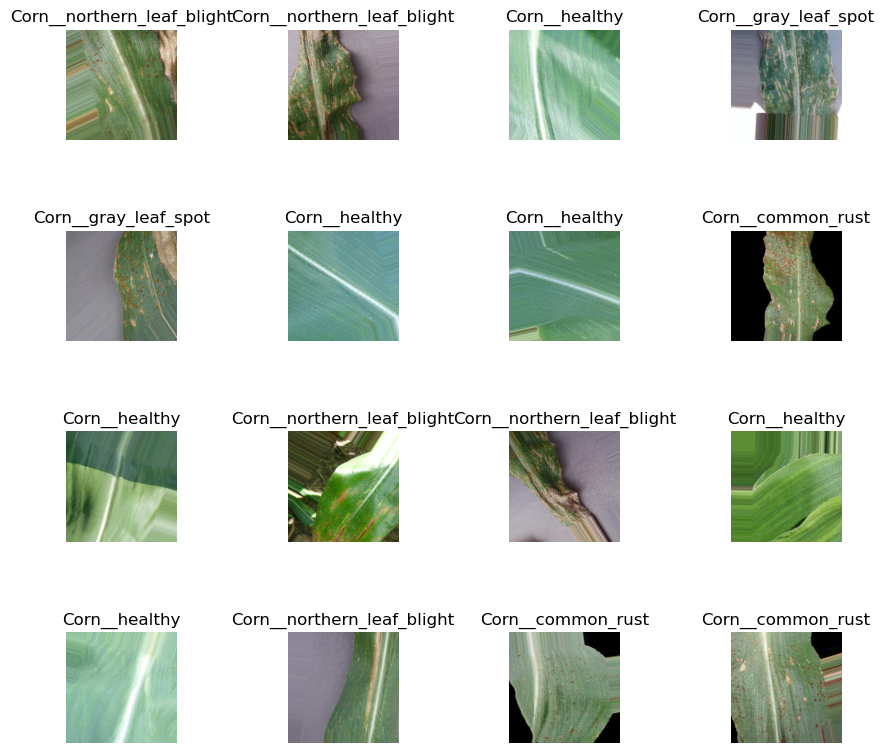

In [8]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

# **5. Callbacks Function**

In [9]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('You entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.total_epochs:
                        print('\nYou specified a maximum of', self.total_epochs, 'epochs. Cannot train for', self.ask_epoch, flush=True)
                    else:
                        print('You entered', ans, 'Training will continue to epoch', self.ask_epoch, flush=True)
                        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current learning rate is {current_lr:7.5f}.')

# **6. Selecting Model**

In [10]:
tf.keras.backend.clear_session()
#del model

In [11]:
# IMAGE_CHANNEL = 3
# IMAGE_SIZE = 224

# model_name = 'MobileNetV3Small'
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
#                                                    include_top=False,
#                                                    weights='imagenet',
#                                                    pooling='max')

# base_model.trainable = True


# **7. Creating Architecture Model**

In [15]:
IMAGE_CHANNEL = 3
IMAGE_SIZE = 224
OUTPUT_SIZE = len(class_names)

#1
# model = Sequential([
#     Conv2D(100, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)+(3,)),
    
#     Dense(64, activation='relu'),
#     Dropout(0.2),
    
#     Dense(16, activation='relu'),
#     Dense(OUTPUT_SIZE, activation='softmax')
# ])

#2
model = Sequential([
    Conv2D(512, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(3, 3)),
    
    Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu', padding='same',strides=(1,1)),
    MaxPooling2D(2,2),
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)+(3,)),
    
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(OUTPUT_SIZE, activation='softmax')
])

# model = Sequential([
#     Conv2D(128, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), padding='same', strides=(1,1)),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1,1)),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1,1)),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Flatten(),
    
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(OUTPUT_SIZE, activation='softmax')
# ])



model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 512)     14336     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 512)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 256)       1179904   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 128)     

# **8. Training Model**

In [16]:
total_epochs = 50
ask_epoch = 49
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, verbose=1)
callbacks = [rlronp_callback, ask_callback]

# **9. Model Validation**

In [17]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Training will proceed until epoch 49 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.4473
Validation loss of  0.8991 is below the lowest loss, saving weights from epoch 1   as the best weights
105/105 [==============================] - 78s 642ms/step - loss: 1.0564 - accuracy: 0.4473 - val_loss: 0.8991 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 0.8831 - accuracy: 0.5679
Validation loss of  0.7484 is below the lowest loss, saving weights from epoch 2   as the best weights
105/105 [==============================] - 60s 569ms/step - loss: 0.8831 - accuracy: 0.5679 - val_loss: 0.7484 - val_accuracy: 0.6366 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6605
Validation loss of  0.5052 is below the lowest loss,

 H


You entered H Training halted on epoch 49 due to user input

105/105 [==============================] - 5439s 52s/step - loss: 0.1834 - accuracy: 0.9298 - val_loss: 0.1737 - val_accuracy: 0.9351 - lr: 1.0000e-06
Loading model with weights from epoch 37
Training elapsed time was 2.0 hours, 25.0 minutes, 26.52 seconds)


# **10. Model Evaluation**

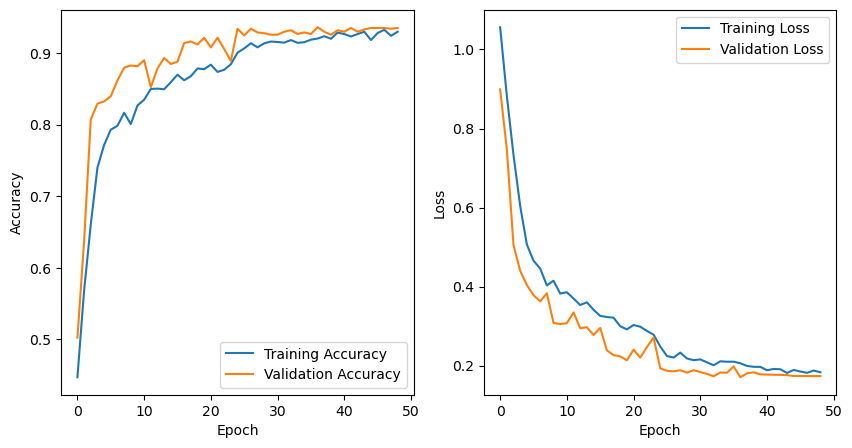

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

16/16 [==============================] - 3s 172ms/step - loss: 0.1743 - accuracy: 0.9337
Test loss: 0.174326553940773 / Test accuracy: 0.933747410774231


# **11. Prediction Test**

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/jagungDeepLearningFinal2.h5")

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.5

uploaded = files.upload()

for fn in uploaded.keys():
  img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), 1 )
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  # Menampilkan gambar
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Mengubah gambar menjadi bentuk dan tipe yang sesuai untuk input model
  input_image = np.expand_dims(img, axis=0)
  input_image = input_image.astype('float32') / 255.0

  # Melakukan prediksi
  prediction = model.predict(input_image)
  #print(input_image)
  predicted_label = np.argmax(prediction)
  predicted_prob = np.max(prediction)

  if predicted_prob < threshold:  # Ganti threshold dengan ambang batas yang sesuai
      predicted_label = "Bukan Tanaman"  # Ganti non_plant_label dengan label "Bukan Tanaman"

  print("Predicted Label:")
  print(predicted_label)
  print("Predicted Probability:")
  rounded_prediction = np.round(prediction[0], decimals=2)
  print(rounded_prediction)  

# **12. Save Model**

In [20]:
model.save('jagungDeepLearningFinal3.h5')